# 机器学习评分卡学习目标：
- 掌握KS值计算方法
- 知道评分映射方法
- 知道XGBoost和LightGBM基本原理
- 掌握使用lightGBM进行特征筛选的方法
- 应用Toad构建评分卡模型


# 1、 什么是Gradient Boosting算法？
`基本原理`：训练一个模型m1，产生一个错误e1，针对e1训练一个模型m2，产生错误e2，针对e2训练第三个模型m3，产生错误e3，以此类推，最终的预测结果是：m1 + m2 + m3……

`核心思想`：GBDT是boosting的一种方法，每次简历单个分类器，是在之前建立的模型的损失函数的梯度下降方法，损失函数越大说明模型跟容易出错，如果我们能让损失函数持续下降，则说明我们的模型在持续不断的改进，而最好的方式就是让损失函数在其梯度的方向上下降
GBDT的核心就在于每一棵树学的都是之前所有树的结论和残差
- 残差就是真实值与预测值之间的差值
- 为了得到残差，GBDT中树全部都是回归树，没有分类树

`GBDT和随机森林的异同点`：

**相同点**：
   - 两者都是基于决策树的集成学习方法。
   - 都适用于回归和分类任务。
   - 都可以通过调整树的数量、深度等超参数来控制模型复杂度。

**不同点**：
   - **核心思想**：GBDT 是 Boosting 方法，强调逐步优化；随机森林是 Bagging 方法，强调多样性。
   - **训练方式**：GBDT 是串行训练，随机森林是并行训练。
   - **对异常值的敏感性**：GBDT 更敏感，随机森林更鲁棒。
   - **适用场景**：GBDT 更适合低噪声数据，随机森林更适合高噪声数据。
    

| **对比维度**            | **GBDT**                                                                                      | **随机森林**                                                                                  |
|-------------------------|----------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|
| **基本思想**            | 基于提升（Boosting）思想，通过迭代训练多个弱学习器，每一轮都关注前一轮的错误进行修正。          | 基于装袋（Bagging）思想，通过并行训练多个独立的决策树，最终通过投票或平均的方式集成结果。      |
| **模型构建方式**        | 串行构建，每棵树依赖于前一棵树的结果，逐步减少残差（误差）。                                   | 并行构建，每棵树独立生成，互不依赖。                                                         |
| **树的数量影响**        | 树的数量过多可能导致过拟合，因为每棵树都在“修正”前一棵树的错误。                               | 树的数量越多通常越稳定，但收益递减，且不会显著增加过拟合风险。                                |
| **样本采样方式**        | 使用全部样本训练每棵树，但通过梯度下降的方式调整每一轮的权重分布。                              | 对样本进行自助采样（Bootstrap Sampling），每棵树使用不同的子集进行训练。                     |
| **特征选择方式**        | 每棵树使用所有特征，通过分裂时的最优特征选择进行建模。                                         | 每棵树在分裂节点时随机选择部分特征，进一步增加了多样性。                                      |
| **对异常值的敏感性**    | 对异常值较为敏感，因为每一轮都会基于残差优化，异常值可能会被过度关注。                           | 对异常值不太敏感，因为每棵树是独立的，异常值的影响会被平均化。                                 |
| **训练速度**            | 训练速度较慢，因为每棵树依赖于前一棵树，无法并行计算。                                          | 训练速度较快，因为每棵树可以独立并行生成。                                                    |
| **预测速度**            | 预测速度较慢，因为需要累加多棵树的预测结果。                                                   | 预测速度较快，因为可以直接通过投票或平均得出结果。                                            |
| **适用场景**            | 更适合处理低噪声数据，擅长捕捉复杂模式，适用于回归和分类问题。                                  | 更适合处理高噪声数据，擅长处理高维稀疏数据，适用于回归和分类问题。                             |
| **防止过拟合的方式**    | 通过限制树的深度、学习率（Shrinkage）、正则化等手段控制模型复杂度。                             | 通过增加树的数量、限制树的深度、随机采样等方式增加模型多样性，从而降低过拟合风险。              |
| **模型解释性**          | 较难解释，因为每棵树都在修正前一棵树的误差，整体模型是一个复杂的加权组合。                      | 较易解释，因为每棵树是独立的，最终结果可以通过投票或平均直观理解。                              |
| **典型实现库**          | XGBoost、LightGBM、CatBoost 等。                                                              | Scikit-learn 中的 `RandomForestClassifier` 和 `RandomForestRegressor`。                       |


`GBDT的优缺点`：

| **优点**                                | **缺点**                                    |
|-----------------------------------------|---------------------------------------------|
| 高预测精度                              | 训练速度较慢                                |
| 处理非线性关系能力强                    | 调参复杂                                    |
| 自动捕捉特征交互                        | 对异常值敏感                                |
| 支持多种损失函数                        | 数据预处理要求较高                          |
| 不容易过拟合（适当调参后）              | 容易过拟合（如果调参不当）                  |
| 易于扩展（如 XGBoost、LightGBM 等）     | 模型解释性较差                              |
|                                         | 内存占用较大                                |

**改进方向**
- 使用改进版框架（如 XGBoost、LightGBM、CatBoost），它们在训练速度、内存占用、特征处理等方面进行了优化。
- 结合其他模型（如深度学习），在特定场景下实现混合建模。



# 2、什么是XGBoost？
`基本原理`：XGBoost（Extreme Gradient Boosting）与GBDT原理相同，它是经过优化的分布式梯度提升库，更高效、灵活、可移植，并且XGBoost是大规模并行Boosting tree 的工具，比GBDT更高效

`和XGBoost区别`： 
- XGBoost生成的CART树考虑了树的复杂度，而GBDT是在剪枝步骤中才考虑了树的复杂度
- XGBoost是拟合上一轮的损失函数的二阶导展开，GBDT是拟合上一轮损失函数一阶展开，因此XGBoost精确性更高且相同训练效果下迭代次数更少
- XGBoost与GBDT都是在主次迭代提高模型性能，但是XGBoost是选取最佳切分点是可以开启多线程进行，提高效率






In [20]:
# 导入pandas包
import pandas as pd
# 导入numpy包
import numpy as np
# 导入random包
import random
# 导入数学包
import math
# 导入sklearn度量工具
from sklearn import metrics
# 导入sklearn度量工具
from sklearn.metrics import roc_auc_score, roc_curve, auc
# 导入model_selection库包含：数据分割、交叉验证、超参数搜索和模型评估
from sklearn.model_selection import train_test_split
# 导入sklearn线性回归库
from sklearn.linear_model import LogisticRegression

# 1、数据读取
data = pd.read_csv('./file/Bcard.txt')
'''
    数据量：95806行
    字段数量：13
    存在空字段：无
    数据类型：float64、object(2)
    占用内存：9.5+ MB
'''
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95806 entries, 0 to 95805
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   obs_mth       95806 non-null  object 
 1   bad_ind       95806 non-null  float64
 2   uid           95806 non-null  object 
 3   td_score      95806 non-null  float64
 4   jxl_score     95806 non-null  float64
 5   mj_score      95806 non-null  float64
 6   rh_score      95806 non-null  float64
 7   zzc_score     95806 non-null  float64
 8   zcx_score     95806 non-null  float64
 9   person_info   95806 non-null  float64
 10  finance_info  95806 non-null  float64
 11  credit_info   95806 non-null  float64
 12  act_info      95806 non-null  float64
dtypes: float64(11), object(2)
memory usage: 9.5+ MB


,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


时间外样本： ['2018-10-31' '2018-07-31' '2018-09-30' '2018-06-30' '2018-11-30']
特征值: person_info    -0.322581
finance_info    0.023810
credit_info     0.000000
act_info        0.217949
td_score        0.675349
jxl_score       0.144072
mj_score        0.186899
Name: 0, dtype: float64 目标值: 0.0
train_ks :  0.4148130573422309
val_ks :  0.3760011269985518


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

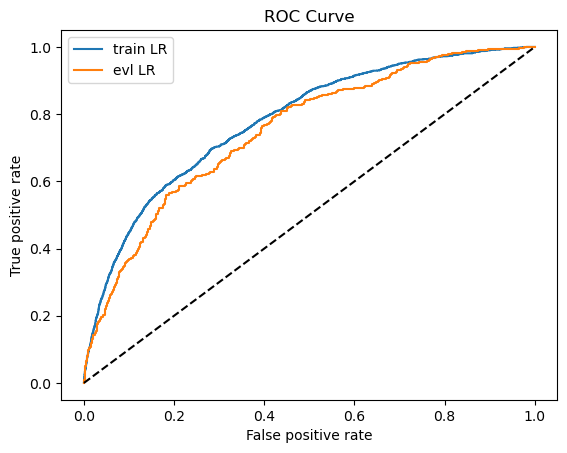

In [3]:
# 1、查看月份分布，用最后一个月作为时间外样本
'''
“时间外样本”（Out-of-Time Sample）是机器学习和数据分析中一个重要的概念，特别是在处理时间序列数据或涉及时间因素的建模任务中。时间外样本是指那些在模型训练过程中未被使用的、时间上更靠后的数据，用于评估模型在新数据上的泛化能力。
'''
print('时间外样本：', data['obs_mth'].unique())

# 2、划分数据集
train = data[data['obs_mth'] != '2018-11-30'].reset_index().copy()
val = data[data['obs_mth'] == '2018-11-30'].reset_index().copy()

# 3、取出建模用到的特征
feature_lst = ['person_info', 'finance_info', 'credit_info', 'act_info', 'td_score', 'jxl_score', 'mj_score',
               'rh_score']

# 4、模型训练
x = train[feature_lst]
y = train['bad_ind']

first_row = x.iloc[0]
print("特征值:", first_row[:-1], "目标值:", y.iloc[0])

val_x = val[feature_lst]
val_y = val['bad_ind']
lr_model = LogisticRegression(C=0.1)
lr_model.fit(x, y)

'''
TPR：表示在所有实际为正的样本中，模型正确预测为正的比例
FPR：表示在所有实际为负的样本中，模型错误预测为正的比例
TPR 衡量模型对正样本的识别能力，而 FPR 衡量模型对负样本的误判能力
'''
# 5、计算测试集和训练集TPR和FPR
# 训练集取出预测值
y_predict = lr_model.predict_proba(x)[:, 1]
# 计算TPR和FPR
fpr_lr_train, tpr_lr_train, _ = roc_curve(y, y_predict)
# 计算KS
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ', train_ks)

# 验证集计算预测值
y_predict = lr_model.predict_proba(val_x)[:, 1]
# 计算预测值
fpr_lr, tpr_lr, _ = roc_curve(val_y, y_predict)
# 计算KS值
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', val_ks)

# 6、绘制图像
from matplotlib import pyplot as plt

plt.plot(fpr_lr_train, tpr_lr_train, label='train LR')  #绘制训练集ROC
plt.plot(fpr_lr, tpr_lr, label='evl LR')  #绘制验证集ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [4]:
# 导入lightGBM包
import lightgbm as lgb
# 导入sklearn中模型选择工具
from sklearn.model_selection import train_test_split


def lgb_test(train_x, train_y, test_x, test_y):
    '''
    lightGBM进行特征筛选
    :param train_x: 
    :param train_y: 
    :param test_x: 
    :param test_y: 
    :return: 
    '''
    clf = lgb.LGBMClassifier(boosting_type='gbdt',
                             objective='binary',
                             metric='auc',
                             learning_rate=0.1,
                             n_estimators=24,
                             max_depth=5,
                             num_leaves=20,
                             max_bin=45,
                             min_data_in_leaf=6,
                             bagging_fraction=0.6,
                             bagging_freq=0,
                             feature_fraction=0.8, )
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], eval_metric='auc')
    return clf, clf.best_score_['valid_1']['auc'],


# 1、数据集划分
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=0, test_size=0.2)

lgb_model, lgb_auc = lgb_test(train_x, train_y, test_x, test_y)
dict_arr = {
    'name': lgb_model.booster_.feature_name(),
    'importance': lgb_model.feature_importances_
}
feature_importance = pd.DataFrame(dict_arr).sort_values(by=['importance'], ascending=False)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.9/site-pac

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.9/site-pac

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.9/site-pac

AttributeError: _ARRAY_API not found

/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.9/site-pac

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.9/site-pac

AttributeError: _ARRAY_API not found

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Number of positive: 1182, number of negative

train_ks :  0.4173085025028503
val_ks :  0.39492219345405577
变量名单： ['person_info', 'finance_info', 'credit_info', 'act_info']
系数： [[ 2.50325724  4.49766948  1.90289775 -1.40657052]]
截距： [-3.92010539]


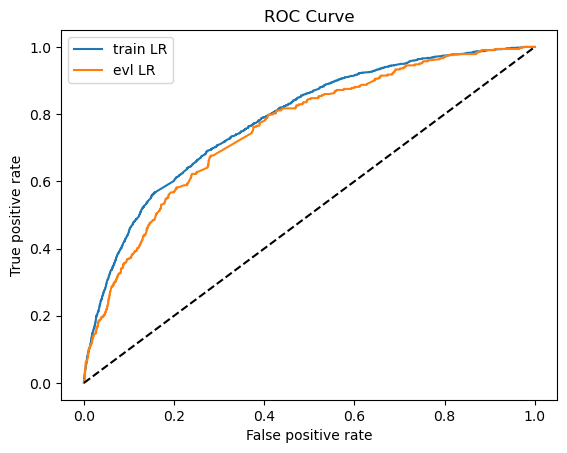

In [21]:
from matplotlib import pyplot as plt

# 1、模型调优，去掉几个特征，重新建模 确定新的特征
feature_lst = ['person_info', 'finance_info', 'credit_info', 'act_info']
x = train[feature_lst]
y = train['bad_ind']

val_x = val[feature_lst]
val_y = val['bad_ind']

# 2、模型训练
lr_model = LogisticRegression(C=0.1)
lr_model.fit(x, y)

# 3、计算FPR和TPR
y_predict = lr_model.predict_proba(x)[:, 1]
fpr_lr_train, tpr_lr_train, _ = roc_curve(y, y_predict)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ', train_ks)

y_predict = lr_model.predict_proba(val_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(val_y, y_predict)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', val_ks)

# 4、打印回归系数
print('变量名单：', feature_lst)
print('系数：', lr_model.coef_)
print('截距：', lr_model.intercept_)

# 5、绘图
plt.plot(fpr_lr_train, tpr_lr_train, label='train LR')
plt.plot(fpr_lr, tpr_lr, label='evl LR')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# 6、生成报告

In [22]:
# 1、准备数据
bins = 20
temp_ = pd.DataFrame()
# 预测结果（坏人概率）
temp_['bad_rate_predict'] = lr_model.predict_proba(val_x)[:, 1]
# 真实结果
temp_['real_bad'] = val_y
# 按照预测坏人概率降序排列
temp_ = temp_.sort_values('bad_rate_predict', ascending=False)
#添加序号列，用于分组
temp_['num'] = [i for i in range(temp_.shape[0])]
#分成20组，为每组添加组号
temp_['num'] = pd.cut(temp_.num, bins=bins, labels=[i for i in range(bins)])

# 2、创建报告
report = pd.DataFrame()
# 计算每一组坏人数量
report['BAD'] = temp_.groupby('num').real_bad.sum().astype(int)
# 计算每一组好人数量
report['GOOD'] = temp_.groupby('num').real_bad.count().astype(int) - report['BAD']
# 累计求和坏人数量
report['BAD_CNT'] = report['BAD'].cumsum()
# 累计求和好人数量
report['GOOD_CNT'] = report['GOOD'].cumsum()
good_total = report.GOOD_CNT.max()
bad_total = report.BAD_CNT.max()
# 计算到当前组坏人比例（占所有坏人比例）
report['BAD_PCTG'] = round(report.BAD_CNT / bad_total, 3)
# 计算当前组坏人概率
report['BADRATE'] = report.apply(lambda x: round(x.BAD / (x.BAD + x.GOOD), 3), axis=1)


# 3、计算KS值
def cal_ks(x):
    '''
    当前箱累计坏人数量/总坏人数量 - 当前箱累计好人数量/好人数量
    :param x: 
    :return: 
    '''
    ks = (x.BAD_CNT / bad_total) - (x.GOOD_CNT / good_total)
    return round(math.fabs(ks), 3)


'''
从报告中可以看出:
1、模型的KS最大值出现在第6箱(编号5),如将箱分的更细,KS值会继续增大,上限为前面通过公式计算出的KS值
2、前4箱的样本占总人数的20%，捕捉负样本占所有负样本的56.4%，如拒绝分数最低的20%的人，可以捕捉到56.4%的负样本。
'''

report['KS'] = report.apply(cal_ks, axis=1)
report



/var/folders/4n/qh91m_wd5fj7fm56fsm72yth0000gp/T/ipykernel_67364/703093461.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  report['BAD'] = temp_.groupby('num').real_bad.sum().astype(int)
/var/folders/4n/qh91m_wd5fj7fm56fsm72yth0000gp/T/ipykernel_67364/703093461.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  report['GOOD'] = temp_.groupby('num').real_bad.count().astype(int) - report['BAD']


,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE,KS
num,,,,,,,
0,68,731,68,731,0.207,0.085,0.161
1,51,748,119,1479,0.363,0.064,0.268
2,35,764,154,2243,0.470,0.044,0.326
3,32,766,186,3009,0.567,0.040,0.375
4,18,781,204,3790,0.622,0.023,0.380
5,19,780,223,4570,0.680,0.024,0.388
6,15,783,238,5353,0.726,0.019,0.383
7,16,783,254,6136,0.774,0.020,0.382
8,14,785,268,6921,0.817,0.018,0.375


In [7]:
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *

mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (
    Line()
    .add_xaxis(report.index.values.tolist())
    .add_yaxis(
        "分组坏人占比",
        list(report.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="KS值",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_yaxis(
        "KS",
        list(report['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
# line.render_notebook()
line.render('./file/评分卡模型表现.html')

'/Users/BrownSugar/PyCharmWorkplace/ai-lesson/STAGE-5 金融风控项目/项目数据处理/file/评分卡模型表现.html'

In [18]:
def score(person_info, finance_info, credit_info, act_info):
    '''
    评分映射
    :param person_info: 
    :param finance_info: 
    :param credit_info: 
    :param act_info: 
    :return: 
    '''
    person_coefficient = 2.48386162
    finance_coefficient = 4.44901224
    credit_coefficient = 1.88254182
    act_coefficient = -1.43356854
    total_coefficient = 3.90631899
    x_beta = person_info * person_coefficient + finance_info * finance_coefficient + credit_info * credit_coefficient + act_info * act_coefficient - total_coefficient
    # 系数 = 基准分 + 系数 * 2^ ((1 - p)/p)
    score = 900 - 50 * x_beta / math.log(2)
    return score


val['score'] = val.apply(lambda x: score(x.person_info, x.finance_info, x.credit_info, x.act_info), axis=1)

fpr_lr, tpr_lr, _ = roc_curve(val_y, val['score'])
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', val_ks)

val_ks :  0.3928959732014397


In [19]:
# 对应评级区间
def level(score):
    '''
    对应评级区间
    :param score: 
    :return: 
    '''
    level = 0
    if score <= 600:
        level = 'D'
    elif 600 < score <= 640:
        level = 'C'
    elif 640 < score <= 680:
        level = 'B'
    elif 680 < score:
        level = 'A'
    return level


val['level'] = val['score'].map(lambda x: level(x))
val.level.groupby(val.level).count() / len(val)

level
A    1.0
Name: level, dtype: float64

In [22]:
# 加载数据
import pandas as pd

data = pd.read_csv('./file/pima-indians-diabetes.csv')
'''
    数据量：768
    字段数量：9 
    数据类型：float64(2)、int64(7)
    为空字段：无
'''
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
# 加载warning日志,忽略提醒日志
import warnings

warnings.filterwarnings('ignore')

# 加载python 中高性能计算库numpy
import numpy as np
# 加载基于numpy构建的数据计算库 pandas
import pandas as pd

# 导入序列化和反序列化
import pickle

# 导入xgboost模型
import xgboost as xgb

# 导入数据拆分库
from sklearn.model_selection import train_test_split

# 导入模型加载库
import joblib

# 1、加载数据
data = pd.read_csv('./file/Pima-Indians-Diabetes.csv')

data.info()
data.head()
# 2、数据切分
train, test = train_test_split(data)

feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
                   'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
train_X = train[feature_columns].values
train_y = train[target_column].values
test_X = test[feature_columns].values
test_y = test[target_column].values

# 3、初始化模型
xgb_classifier = xgb.XGBClassifier(n_estimators=20, max_depth=4, learning_rate=0.1, subsample=0.7, colsample_bytree=0.7)

# 4、拟合模型
xgb_classifier.fit(train_X, train_y)

# 5、使用模型预测
predict = xgb_classifier.predict(test_X)

# 6、判断准确率
print('错误类为%f' % ((predict != test_y).sum() / float(test_y.shape[0])))

# 模型存储
joblib.dump(xgb_classifier, './file/2.model')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
错误类为0.250000


['./file/2.model']

In [24]:
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 273.5 kB/s eta 0:00:00a 0:00:02


In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import datasets

# from xgboost.callback import EarlyStopping
# 
# callbacks = [EarlyStopping(rounds=10)]

digits = datasets.load_digits()
X = digits['data']
y = digits['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier(
    early_stopping_rounds=10,
    eval_metric="auc")
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# callbacks = [EarlyStopping(rounds=10)]
# clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=[(X_test, y_test)])
# clf.fit(X_train, y_train, callbacks=callbacks, eval_metric="auc", eval_set=[(X_test, y_test)])
# clf.fit(X_train, y_train,  eval_set=[(X_test, y_test)])


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.9/site-pac

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.9/site-pac

AttributeError: _ARRAY_API not found

[0]	validation_0-auc:0.98554
[1]	validation_0-auc:0.99123
[2]	validation_0-auc:0.99278
[3]	validation_0-auc:0.99366
[4]	validation_0-auc:0.99408
[5]	validation_0-auc:0.99492
[6]	validation_0-auc:0.99567
[7]	validation_0-auc:0.99607
[8]	validation_0-auc:0.99652
[9]	validation_0-auc:0.99681
[10]	validation_0-auc:0.99718
[11]	validation_0-auc:0.99747
[12]	validation_0-auc:0.99753
[13]	validation_0-auc:0.99770
[14]	validation_0-auc:0.99795
[15]	validation_0-auc:0.99808
[16]	validation_0-auc:0.99815
[17]	validation_0-auc:0.99828
[18]	validation_0-auc:0.99834
[19]	validation_0-auc:0.99844
[20]	validation_0-auc:0.99853
[21]	validation_0-auc:0.99854
[22]	validation_0-auc:0.99867
[23]	validation_0-auc:0.99869
[24]	validation_0-auc:0.99876
[25]	validation_0-auc:0.99877
[26]	validation_0-auc:0.99880
[27]	validation_0-auc:0.99885
[28]	validation_0-auc:0.99885
[29]	validation_0-auc:0.99890
[30]	validation_0-auc:0.99890
[31]	validation_0-auc:0.99891
[32]	validation_0-auc:0.99891
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [3]:
# 使用Xgboost输出特征重要程度

import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets

iris = datasets.load_iris()
y = iris['target']
X = iris['data']
xgb_model = xgb.XGBClassifier().fit(X, y)

temp = pd.DataFrame()
temp['feature_names'] = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
temp['feature_importances'] = xgb_model.feature_importances_
temp = temp.sort_values('feature_importances', ascending=False)
temp


,feature_names,feature_importances
2,petal_length,0.676586
3,petal_width,0.297366
1,sepal_width,0.016450
0,sepal_length,0.009598


<Axes: xlabel='feature_names'>

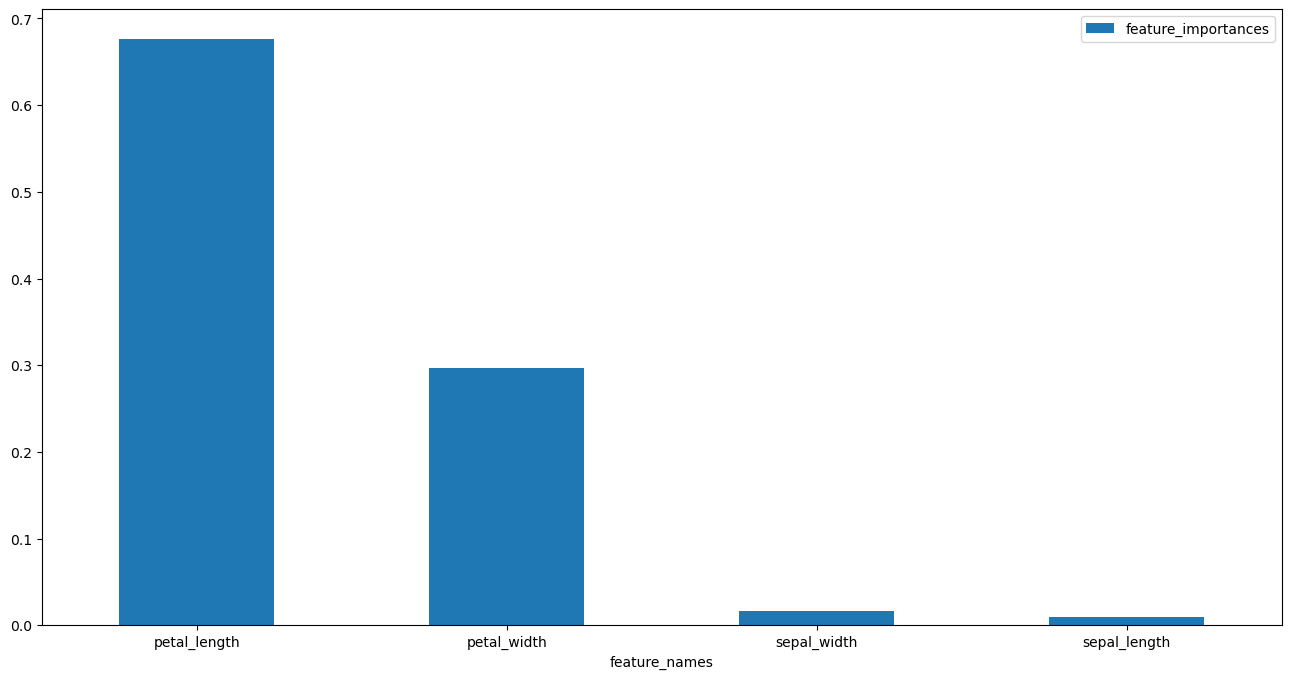

In [4]:
temp.set_index('feature_names').plot.bar(figsize=(16, 8), rot=0)

In [6]:
# LightGBM

import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math
import time
import lightgbm as lgb

data = pd.read_csv('./file/Bcard.txt')
data.head()


,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [7]:
# 采用相同的方式划分测试集验证集
df_train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

In [8]:
# 使用LightGBM的特征重要性以及夸时间交叉验证方式进行特征筛选 
df_train = df_train.sort_values(by='obs_mth', ascending=False)
df_train.head()

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
33407,33407,2018-10-31,0.0,A2810176,0.146055,0.079922,0.250568,0.045240,0.766906,0.413713,0.013863,0.023810,0.00,0.269231
33383,33383,2018-10-31,0.0,A2807687,0.551366,0.300781,0.225007,0.045447,0.735733,0.684182,-0.261014,0.071429,0.03,0.269231
33379,33379,2018-10-31,0.0,A2807232,0.708547,0.769513,0.928457,0.739716,0.947453,0.361551,-0.128677,0.047619,0.00,0.269231
33376,33376,2018-10-31,0.0,A2806932,0.482248,0.116658,0.286273,0.056618,0.047024,0.890433,0.078853,0.047619,0.00,0.269231


In [9]:
# 将数据按照时间先后顺序分成5组
df_train['rank'] = [i for i in range(df_train.shape[0])]
df_train['rank'] = pd.cut(df_train['rank'], bins=5, labels=[i for i in range(5)])
df_train.head()

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,rank
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949,0
33407,33407,2018-10-31,0.0,A2810176,0.146055,0.079922,0.250568,0.045240,0.766906,0.413713,0.013863,0.023810,0.00,0.269231,0
33383,33383,2018-10-31,0.0,A2807687,0.551366,0.300781,0.225007,0.045447,0.735733,0.684182,-0.261014,0.071429,0.03,0.269231,0
33379,33379,2018-10-31,0.0,A2807232,0.708547,0.769513,0.928457,0.739716,0.947453,0.361551,-0.128677,0.047619,0.00,0.269231,0
33376,33376,2018-10-31,0.0,A2806932,0.482248,0.116658,0.286273,0.056618,0.047024,0.890433,0.078853,0.047619,0.00,0.269231,0


In [10]:
# 查看分组后，每组的数据量
df_train['rank'].value_counts()

rank
0    15967
1    15966
2    15966
3    15966
4    15966
Name: count, dtype: int64

In [11]:
# 查看数据总量，与每组相加结果吻合
len(df_train)

79831

In [14]:
# 使用lgbm进行分组交叉特征筛选
lst = ['td_score', 'jxl_score', 'mj_score', 'rh_score', 'zzc_score', 'zcx_score', 'person_info',
       'finance_info', 'credit_info', 'act_info']


#定义lgb函数
def LGB_test(train_x, train_y, test_x, test_y):
    from multiprocessing import cpu_count
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=31,
        reg_alpha=0.0,
        reg_lambda=1,
        max_depth=2,
        n_estimators=800,
        max_features=140,
        objective='binary',
        subsample=0.7,
        colsample_bytree=0.7,
        subsample_freq=1,
        learning_rate=0.05,
        min_child_weight=50,
        random_state=None,
        n_jobs=cpu_count() - 1,
        early_stopping_rounds=100,
        num_iterations=800  #迭代次数
    )
    clf.fit(
        train_x,
        train_y,
        eval_metric='auc',
        eval_set=[(train_x, train_y), (test_x, test_y)],

    )
    print(clf.n_features_)
    return clf, clf.best_score_['valid_1']['auc']


feature_lst = []
ks_train_lst = []
ks_test_lst = []
for rk in set(df_train['rank']):
    # 0，1，2，3，4，

    # 1、定义模型训练集与测试集
    t_test = df_train[df_train['rank'] == rk]
    t_train = df_train[df_train['rank'] != rk]

    train = t_train[lst]
    train_y = t_train.bad_ind

    test = t_test[lst]
    test_y = t_test.bad_ind
    model, auc = LGB_test(train, train_y, test, test_y)

    # 2、模型贡献度放在feature中
    feature = pd.DataFrame(
        {'name': model.booster_.feature_name(),
         'importance': model.feature_importances_
         }).set_index('name')
    feature_lst.append(feature)

    # 3、计算训练集、测试集、验证集上的KS和AUC

    y_predict_train_lgb = model.predict_proba(train)[:, 1]
    y_predict_test_lgb = model.predict_proba(test)[:, 1]

    train_fpr_lgb, train_tpr_lgb, _ = roc_curve(train_y, y_predict_train_lgb)
    test_fpr_lgb, test_tpr_lgb, _ = roc_curve(test_y, y_predict_test_lgb)

    train_ks = abs(train_fpr_lgb - train_tpr_lgb).max()
    test_ks = abs(test_fpr_lgb - test_tpr_lgb).max()

    train_auc = metrics.auc(train_fpr_lgb, train_tpr_lgb)
    test_auc = metrics.auc(test_fpr_lgb, test_tpr_lgb)

    ks_train_lst.append(train_ks)
    ks_test_lst.append(test_ks)

train_ks = np.mean(ks_train_lst)
test_ks = np.mean(ks_test_lst)

print('train_ks: ', train_ks)
print('test_ks: ', test_ks)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 1054, number of negative: 62810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 63864, number of used features: 10
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016504 -> initscore=-4.087522
[LightGBM] [Info] Start training from score -4.087522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [15]:
feature_importance = pd.concat(feature_lst, axis=1).mean(1).sort_values(ascending=False)
feature_importance[(feature_importance > 20)].index.tolist()

['finance_info', 'person_info', 'credit_info', 'act_info']

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 1470, number of negative: 78361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 79831, number of used features: 4
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018414 -> initscore=-3.976064
[LightGBM] [Info] Start training from score -3.976064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
T

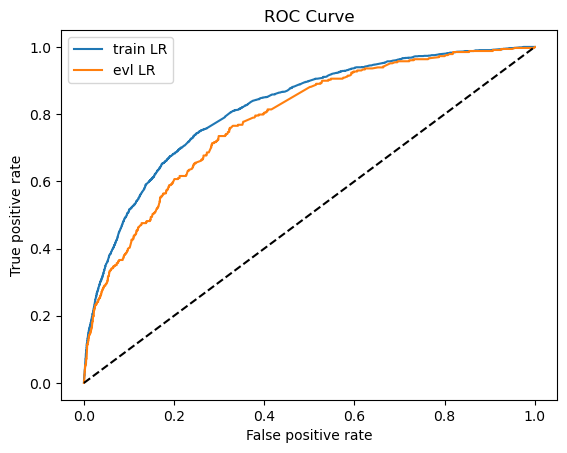

In [23]:
# 最终筛选出4个特征
current_list = ['person_info', 'finance_info', 'credit_info', 'act_info']

train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
evl = data[data.obs_mth == '2018-11-30'].reset_index().copy()

x = train[current_list]
y = train['bad_ind']

evl_x = evl[current_list]
evl_y = evl['bad_ind']

model, auc = LGB_test(x, y, evl_x, evl_y)

y_predict = model.predict_proba(x)[:, 1]
fpr_lgb_train, tpr_lgb_train, _ = roc_curve(y, y_predict)
train_ks = abs(fpr_lgb_train - tpr_lgb_train).max()
print('train_ks : ', train_ks)

y_predict = model.predict_proba(evl_x)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(evl_y, y_predict)
evl_ks = abs(fpr_lgb - tpr_lgb).max()
print('evl_ks : ', evl_ks)

from matplotlib import pyplot as plt

plt.plot(fpr_lgb_train, tpr_lgb_train, label='train LR')
plt.plot(fpr_lgb, tpr_lgb, label='evl LR')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [24]:
'''
1、从结果中看出，LightGBM效比LR要好，但LR通过一些处理，模型表现也会有提升
2、将集成学习评分卡结果转换成分数
'''


def score(xbeta):
    '''
    好人的概率/坏人的概率
    :param xbeta: 
    :return: 
    '''
    score = 600 + 50 * (math.log2((1 - xbeta) / xbeta))
    return score


evl['xbeta'] = model.predict_proba(evl_x)[:, 1]
evl['score'] = evl.apply(lambda x: score(x.xbeta), axis=1)
evl['score']

[LightGBM] [Warning] Unknown parameter: max_features


0        799.044524
1        981.994370
2        911.925133
3        907.718692
4        981.994370
            ...    
15970    761.518532
15971    901.987537
15972    901.987537
15973    883.922367
15974    785.625330
Name: score, Length: 15975, dtype: float64

In [18]:
# 用转换的分数验证KS值
fpr, tpr, _ = roc_curve(evl_y, evl['score'])
val_ks = abs(fpr - tpr).max()
val_ks

np.float64(0.43591286882703295)

In [25]:
# 生成模型报告

# 1、准备数据
bins = 20
temp_ = pd.DataFrame()  #创建空白DataFrame
temp_['bad_rate_predict'] = evl['score']  # 预测结果（坏人概率）
temp_['real_bad'] = val_y  # 真实结果
temp_ = temp_.sort_values('bad_rate_predict')  #按照预测坏人概率降序排列
temp_['num'] = [i for i in range(temp_.shape[0])]  #添加序号列，用于分组
temp_['num'] = pd.cut(temp_.num, bins=bins, labels=[i for i in range(bins)])  #分成20组，为每组添加组号

# 2、创建报告
#创建空白DataFrame
report = pd.DataFrame()
#计算每一组坏人数量
report['BAD'] = temp_.groupby('num').real_bad.sum().astype(int)
#计算每一组好人数量
report['GOOD'] = temp_.groupby('num').real_bad.count().astype(int) - report['BAD']
#累计求和坏人数量
report['BAD_CNT'] = report['BAD'].cumsum()
#累计求和好人数量
report['GOOD_CNT'] = report['GOOD'].cumsum()
good_total = report.GOOD_CNT.max()
bad_total = report.BAD_CNT.max()
#计算到当前组坏人比例（占所有坏人比例）
report['BAD_PCTG'] = round(report.BAD_CNT / bad_total, 3)
#计算当前组坏人概率
report['BADRATE'] = report.apply(lambda x: round(x.BAD / (x.BAD + x.GOOD), 3), axis=1)


# 3、计算KS值
def cal_ks(x):
    #当前箱累计坏人数量/总坏人数量  - 当前箱累计好人数量/好人数量
    ks = (x.BAD_CNT / bad_total) - (x.GOOD_CNT / good_total)
    return round(math.fabs(ks), 3)


report['KS'] = report.apply(cal_ks, axis=1)
report

/var/folders/4n/qh91m_wd5fj7fm56fsm72yth0000gp/T/ipykernel_67364/869003559.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  report['BAD'] = temp_.groupby('num').real_bad.sum().astype(int)
/var/folders/4n/qh91m_wd5fj7fm56fsm72yth0000gp/T/ipykernel_67364/869003559.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  report['GOOD'] = temp_.groupby('num').real_bad.count().astype(int) - report['BAD']


,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE,KS
num,,,,,,,
0,94,705,94,705,0.287,0.118,0.242
1,33,766,127,1471,0.387,0.041,0.293
2,31,768,158,2239,0.482,0.039,0.339
3,35,763,193,3002,0.588,0.044,0.397
4,18,781,211,3783,0.643,0.023,0.402
5,24,775,235,4558,0.716,0.030,0.425
6,16,782,251,5340,0.765,0.020,0.424
7,11,788,262,6128,0.799,0.014,0.407
8,12,787,274,6915,0.835,0.015,0.393


In [27]:
# pyecharts绘图展示模型表现

from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *

mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis(list(report.index))
    .add_yaxis(
        "分组坏人占比",
        list(report.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_yaxis(
        "KS",
        list(report['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
# line.render_notebook()
line.render('./file/评分卡模型表现-LightGBM.html')

'/Users/BrownSugar/PyCharmWorkplace/ai-lesson/STAGE-5 金融风控项目/项目数据处理/file/评分卡模型表现-LightGBM.html'

In [11]:
# 整体流程梳理

import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import math
import xgboost as xgb
import toad
print(np.__version__)  # 确保版本正确

# 加载数据
data_all = pd.read_csv("./file/scorecard.txt")
# data_all.info()
# data_all.head()

# 指定不参与训练列名  
ex_lis = ['uid', 'samp_type', 'bad_ind']
# 参与训练列名  
ft_lis = list(data_all.columns)
for i in ex_lis:
    ft_lis.remove(i)

# 开发样本、验证样本与时间外样本  
dev = data_all[(data_all['samp_type'] == 'dev')]
val = data_all[(data_all['samp_type'] == 'val')]
off = data_all[(data_all['samp_type'] == 'off')]


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [1]:
print(np.__version__)  # 确保版本正确
print(pd.__version__)  # 确保版本正确

NameError: name 'np' is not defined

In [9]:
!pip list | grep -E 'numpy|pandas|scipy'

numpy                             2.0.2
numpydoc                          1.7.0
pandas                            2.2.3
scipy                             1.13.1


In [ ]:
!pip uninstall numpy scipy pandas

In [8]:
!pip install --upgrade numpy scipy pandas